In [147]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask
import rasterio as rio
import numpy as np
import seaborn as sb
import sys
from importlib import reload
sys.path.append('..')
from spectral_analysis.data import munge

In [221]:
reload(munge)

<module 'spectral_analysis.data.munge' from '/Users/christine/Projects/spectral_analysis/notebooks/../spectral_analysis/data/munge.py'>

In [249]:
sb.set_context("talk") 

In [19]:
pd.set_option('display.max_rows', 100)

In [2]:
client = Client()

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59052 instead
  warnings.warn(
2022-05-09 18:35:38,250 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/christine/Projects/spectral_analysis/notebooks/dask-worker-space/worker-ewdnrx9o', purging
2022-05-09 18:35:38,250 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/christine/Projects/spectral_analysis/notebooks/dask-worker-space/worker-4vyunopp', purging
2022-05-09 18:35:38,251 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/christine/Projects/spectral_analysis/notebooks/dask-worker-space/worker-6b2xumse', purging


In [29]:
HySpexPth = Path("/Volumes/FIREICE/fihyper/cwaigl/")
subpath = "03_products/cropped_masked_final/"
filepatt = "VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"

---

Testing 1-2-3

In [195]:
locations_fn = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/GIS/veg_locations/CW_pixel_labels01.gpkg") 

In [196]:
vegsamples = gp.read_file(locations_fn)
vegsamples

,fileprefix,flightline,species,vegclass,context,geometry
0,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.000 7176015.968)
1,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.075 7176011.042)
2,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.000 7176012.012)
3,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437412.061 7176012.982)
4,20210803-BC,03,understory,Open Black Spruce Forest,semi-shade,POINT (437421.091 7176034.999)
...,...,...,...,...,...,...
855,20210803-BC,04,quaking aspen,None,crown,POINT (436797.075 7178624.945)
856,20210803-BC,04,quaking aspen,None,crown,POINT (436797.075 7178625.807)
857,20210803-BC,04,quaking aspen,None,crown,POINT (436788.972 7178624.055)
858,20210803-BC,04,quaking aspen,None,crown,POINT (436800.063 7178615.981)


In [197]:
vegsamples[vegsamples.context=='shade'].species.value_counts()

understory    68
gravel        24
graminoid     10
Name: species, dtype: int64

In [198]:
vegsamples[['species', 'context', ]].value_counts(sort=False)

species                      context   
alder                        crown           9
alder/willow                 crown           1
asphalt                      open           33
black spruce                 crown          50
dead wood                    open            4
graminoid                    crown           4
                             open           67
                             semi-shade      2
                             shade          10
gravel                       open           19
                             semi-shade      7
                             shade          24
paper birch                  crown          86
quaking aspen                crown          79
                             semi-shade     10
sedges dead                  open           12
shrub (betula nana / salix)  open           10
                             open           10
shrub (rose/bearberry)       open           11
tamarack                     crown           8
understory          

In [278]:
vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown')].species.value_counts()

white spruce     71
quaking aspen    58
paper birch      51
black spruce     25
tamarack          6
alder             6
understory        1
alder/willow      1
graminoid         1
Name: species, dtype: int64

In [200]:
subsample = pd.concat([
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='black spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='black spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='paper birch')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='paper birch')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='quaking aspen')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='quaking aspen')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='open') & (vegsamples.species=='graminoid')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='open') & (vegsamples.species=='graminoid')].sample(n=10),
    vegsamples[(vegsamples.context=='open') & (vegsamples.species=='gravel')],
])

In [201]:
subsample[['fileprefix', 'flightline']].drop_duplicates() 

,fileprefix,flightline
559,20210803-BC,04
833,20210803-BC,03
84,20200830-BC,04
796,20210803-BC,01
742,20200830-BC,05
606,20200830-BC,03
639,20210803-BC,06
658,20200830-BC,02
689,20210803-BC,02


In [202]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
559,20210803-BC,04,white spruce,None,crown,POINT (436700.046 7178215.974)
833,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437043.119 7176675.094)
562,20210803-BC,04,white spruce,None,crown,POINT (436685.995 7178216.899)
404,20210803-BC,03,white spruce,Open Quaking Aspen/Spruce Forest,crown,POINT (436784.123 7176128.022)
289,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436993.113 7176332.828)
...,...,...,...,...,...,...
554,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
555,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
556,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
557,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [203]:
def get_datafile(row, smooth=True):
    fpth = HySpexPth / f"{row.fileprefix.replace('-', '_')}" / subpath / f"{row.fileprefix}_{row.flightline}_{filepatt}"
    return fpth

In [204]:
def get_singlefilesampledf(labelrow, sampledf=subsample):
    return sampledf[(sampledf.fileprefix==labelrow.fileprefix) & (sampledf.flightline==labelrow.flightline)]

def get_dataset(fpth):
    testdata = xr.open_dataset(fpth, engine="rasterio")
    testdata.attrs['long_name'] = "spectral reflectance, %*100"
    testdata.attrs['name'] = "spectral reflectance, %*100"
    testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"
    return testdata

def get_spectra_fromsingle(samplerow, dataset='dummy'):
    pt = samplerow.geometry
    spectrum = dataset.band_data.sel(x=pt.x, y=pt.y, method='nearest').values[:-10]
    return spectrum

def get_spectra(labelrow, sampledf=subsample):
    results = []
    subsubsample = get_singlefilesampledf(labelrow, sampledf)
    fn = get_datafile(labelrow)
    print(f"working on {fn}")
    testdata = get_dataset(fn)
    print("Got dataset opened") 
    for idx, row in subsubsample.iterrows():
        print(f"   working on {idx}, {row.species} at {row.geometry}") 
        spectrum = get_spectra_fromsingle(row, dataset=testdata)
        dictitem = {
            'fid': idx,
            'species': row.species,
            'event': row.fileprefix,
            'flightline': row.flightline,
            'vegclass': row.vegclass,
            'context': row.context,
            'spectrum': spectrum,
            }
        results.append(dictitem)
    return results
    testdata.close()

In [205]:
labeldf = subsample[['fileprefix', 'flightline']].drop_duplicates()
samplespectra = []
for idx, row in labeldf.iterrows():
    samplespectra.extend(get_spectra(row))

working on /Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
Got dataset opened
   working on 559, white spruce at POINT (436700.04559270106 7178215.974333572)
   working on 562, white spruce at POINT (436685.99462613644 7178216.898739267)
   working on 566, paper birch at POINT (436701.09325248876 7178198.965268783)
   working on 568, paper birch at POINT (436422.01987703616 7175690.955974042)
   working on 571, paper birch at POINT (436413.1833948301 7175684.920341107)
   working on 852, quaking aspen at POINT (436914.13459565747 7180045.900420736)
   working on 818, quaking aspen at POINT (436854.1678951614 7176666.76104439)
   working on 854, quaking aspen at POINT (436789.08664138854 7178625.002813532)
   working on 849, quaking aspen at POINT (436903.96295599494 7180037.912522921)
   working on 853, quaking aspen at POINT (436911.1175838932 7180052.1068449365)
   working on 858, quaking aspen at POINT (

In [206]:
samplespectra_forplot = samplespectra

In [207]:
samplespectra_forplot[0]

{'fid': 559,
 'species': 'white spruce',
 'event': '20210803-BC',
 'flightline': '04',
 'vegclass': None,
 'context': 'crown',
 'spectrum': array([ 108.,  148.,  109.,  138.,  115.,  126.,  127.,  191.,  162.,
         178.,  198.,  193.,  189.,  179.,  185.,  196.,  208.,  187.,
         182.,  183.,  179.,  194.,  214.,  186.,  193.,  211.,  215.,
         205.,  227.,  238.,  251.,  263.,  282.,  304.,  358.,  385.,
         425.,  486.,  524.,  553.,  566.,  574.,  605.,  621.,  617.,
         632.,  620.,  633.,  604.,  573.,  537.,  504.,  495.,  476.,
         452.,  442.,  428.,  445.,  434.,  436.,  424.,  396.,  395.,
         391.,  370.,  371.,  346.,  355.,  348.,  349.,  338.,  353.,
         327.,  321.,  316.,  306.,  297.,  300.,  275.,  271.,  256.,
         245.,  262.,  238.,  257.,  260.,  268.,  298.,  488.,  678.,
         868., 1058., 1248., 1438., 1629., 1819., 2009., 2198., 2388.,
        2579., 2769., 2959., 3149., 3339., 3529., 3626., 3668., 3772.,
        3

In [208]:
spectra_forplot = pd.DataFrame.from_records(samplespectra_forplot)

In [209]:
spectra_forplot[spectra_forplot.species == 'white spruce']

,fid,species,event,flightline,vegclass,context,spectrum
0,559,white spruce,20210803-BC,04,None,crown,"[108.0, 148.0, 109.0, 138.0, 115.0, 126.0, 127..."
1,562,white spruce,20210803-BC,04,None,crown,"[153.0, 163.0, 192.0, 198.0, 207.0, 211.0, 248..."
19,833,white spruce,20210803-BC,03,Open White Spruce Forest,crown,"[175.0, 147.0, 158.0, 175.0, 176.0, 198.0, 211..."
20,404,white spruce,20210803-BC,03,Open Quaking Aspen/Spruce Forest,crown,"[220.0, 228.0, 189.0, 243.0, 209.0, 229.0, 255..."
21,289,white spruce,20210803-BC,03,Closed White Spruce Forest,crown,"[255.0, 214.0, 191.0, 225.0, 228.0, 252.0, 292..."
22,830,white spruce,20210803-BC,03,Open White Spruce Forest,crown,"[213.0, 219.0, 210.0, 201.0, 228.0, 219.0, 286..."
23,413,white spruce,20210803-BC,03,Closed Spruce/Paper Birch Forest,crown,"[147.0, 161.0, 139.0, 197.0, 166.0, 213.0, 176..."
24,440,white spruce,20210803-BC,03,Open White Spruce Forest,crown,"[125.0, 98.0, 135.0, 124.0, 109.0, 123.0, 138...."
25,295,white spruce,20210803-BC,03,Closed White Spruce Forest,crown,"[117.0, 200.0, 190.0, 184.0, 166.0, 205.0, 246..."
26,342,white spruce,20210803-BC,03,Closed Quaking Aspen/White Spruce Forest,crown,"[262.0, 266.0, 257.0, 293.0, 282.0, 300.0, 295..."


In [210]:
munge.smooth_spectrum(spectra_forplot.iloc[0].spectrum)

array([ 119.47619 ,  123.07143 ,  125.5     ,  126.7619  ,  115.190475,
        132.33333 ,  142.38095 ,  159.85715 ,  175.4762  ,  186.95238 ,
        186.90475 ,  192.85715 ,  188.38095 ,  183.42857 ,  189.33333 ,
        194.57143 ,  196.71428 ,  193.2381  ,  184.5238  ,  178.38095 ,
        188.42857 ,  193.95238 ,  195.5238  ,  198.61905 ,  201.04762 ,
        200.7619  ,  210.14285 ,  216.4762  ,  223.66667 ,  235.42857 ,
        251.04762 ,  261.66666 ,  283.66666 ,  312.38095 ,  345.85715 ,
        388.14285 ,  434.90475 ,  479.14285 ,  521.7619  ,  549.0952  ,
        566.5238  ,  584.9524  ,  599.2381  ,  615.4762  ,  623.7143  ,
        628.0952  ,  628.8095  ,  622.9524  ,  603.      ,  573.2381  ,
        538.0952  ,  512.1429  ,  489.61905 ,  472.4762  ,  454.42856 ,
        441.85715 ,  435.8095  ,  436.61905 ,  438.2857  ,  432.2381  ,
        417.85715 ,  407.57144 ,  393.09525 ,  385.14285 ,  375.38095 ,
        364.0476  ,  354.85715 ,  352.0476  ,  345.90475 ,  349.

In [281]:
labeldf = vegsamples[['fileprefix', 'flightline']].drop_duplicates()
samplespectra = []
for idx, row in labeldf.iterrows():
    samplespectra.extend(get_spectra(row, sampledf=vegsamples))

working on /Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq
Got dataset opened
   working on 0, black spruce at POINT (437393.9999566694 7176015.967750257)
   working on 1, black spruce at POINT (437394.07458888466 7176011.042024051)
   working on 2, black spruce at POINT (437393.9999566694 7176012.012242849)
   working on 3, black spruce at POINT (437412.0609527587 7176012.982461647)
   working on 4, understory at POINT (437421.09145080333 7176034.998965144)
   working on 5, understory at POINT (437422.13630181673 7176034.998965144)
   working on 6, black spruce at POINT (437419.1510132069 7176033.879481915)
   working on 7, understory at POINT (437421.09145080333 7176011.937610634)
   working on 8, understory at POINT (437422.13630181673 7176012.161507279)
   working on 9, black spruce at POINT (437426.9873958077 7176009.997173037)
   working on 10, black spruce at POINT (437430.1965810632 7176009.92254082

In [282]:
spectra_fortraining = pd.DataFrame.from_records(samplespectra)

In [283]:
spectra_fortraining

,fid,species,event,flightline,vegclass,context,spectrum
0,0,black spruce,20210803-BC,03,Open Black Spruce Forest,crown,"[120.0, 100.0, 75.0, 109.0, 104.0, 106.0, 154...."
1,1,black spruce,20210803-BC,03,Open Black Spruce Forest,crown,"[31.0, 101.0, 89.0, 133.0, 109.0, 145.0, 151.0..."
2,2,black spruce,20210803-BC,03,Open Black Spruce Forest,crown,"[104.0, 78.0, 78.0, 111.0, 121.0, 94.0, 99.0, ..."
3,3,black spruce,20210803-BC,03,Open Black Spruce Forest,crown,"[70.0, 95.0, 108.0, 132.0, 125.0, 131.0, 172.0..."
4,4,understory,20210803-BC,03,Open Black Spruce Forest,semi-shade,"[55.0, 41.0, 64.0, 76.0, 102.0, 112.0, 139.0, ..."
...,...,...,...,...,...,...,...
855,788,water,20200830-BC,06,river,open,"[476.0, 385.0, 474.0, 456.0, 495.0, 419.0, 504..."
856,789,water,20200830-BC,06,river,open,"[525.0, 449.0, 502.0, 528.0, 451.0, 446.0, 534..."
857,790,water,20200830-BC,06,river,open,"[412.0, 387.0, 350.0, 430.0, 448.0, 448.0, 575..."
858,791,water,20200830-BC,06,river,open,"[403.0, 386.0, 380.0, 402.0, 456.0, 462.0, 508..."


In [304]:
spectra_fortraining[['species', 'event', 'context']].value_counts()

species                      event        context   
white spruce                 20200830-BC  crown         71
                             20210803-BC  crown         66
understory                   20210803-BC  semi-shade    64
quaking aspen                20200830-BC  crown         58
paper birch                  20200830-BC  crown         51
understory                   20200830-BC  semi-shade    49
graminoid                    20200830-BC  open          35
understory                   20210803-BC  shade         35
paper birch                  20210803-BC  crown         35
understory                   20200830-BC  shade         33
graminoid                    20210803-BC  open          32
black spruce                 20200830-BC  crown         25
                             20210803-BC  crown         25
quaking aspen                20210803-BC  crown         21
asphalt                      20210803-BC  open          17
                             20200830-BC  open          16
und

---


In [298]:
selected_band_idx = np.array([284,
 1,
 235,
 346,
 152,
 311,
 49,
 238,
 364,
 119,
 87,
 250,
 409,
 117,
 361,
 189,
 54,
 303,
 218,
 85,
 252,
 149,
 362,
 173,
 428,
 14,
 217,
 260,
 104,
 368,
 96,
 421,
 9,
 218,
 330,
 107,
 431,
 41,
 253,
 187,
 349,
 92,
 312,
 33,
 218,
 407,
 157,
 370,
 27,
 217])

In [299]:
hyspex_wavelengths[selected_band_idx]

array([1563.42,  413.53, 1297.12, 1900.36,  892.14, 1710.15,  565.67,
       1313.43, 1998.18,  787.55,  686.12, 1378.64, 2242.73,  781.21,
       1981.87, 1047.14,  581.52, 1666.67, 1204.74,  679.78, 1389.51,
        882.63, 1987.31,  960.18, 2345.99,  454.74, 1199.3 , 1432.99,
        740.  , 2019.92,  714.64, 2307.95,  438.89, 1204.74, 1813.4 ,
        749.51, 2362.29,  540.32, 1394.95, 1036.27, 1916.66,  701.96,
       1715.58,  514.96, 1204.74, 2231.86,  907.99, 2030.79,  495.94,
       1199.3 ])

PLOTTING

In [190]:
spectra_forplot

,fid,species,event,flightline,vegclass,context,spectrum
0,552,white spruce,20210803-BC,03,None,crown,"[137.0, 115.0, 98.0, 128.0, 138.0, 108.0, 150...."
1,293,white spruce,20210803-BC,03,Closed White Spruce Forest,crown,"[175.0, 145.0, 162.0, 226.0, 199.0, 157.0, 257..."
2,423,white spruce,20210803-BC,03,Closed Spruce/Paper Birch Forest,crown,"[186.0, 233.0, 191.0, 239.0, 238.0, 230.0, 239..."
3,300,white spruce,20210803-BC,03,Closed White Spruce Forest,crown,"[108.0, 68.0, 120.0, 92.0, 115.0, 112.0, 122.0..."
4,292,white spruce,20210803-BC,03,Closed White Spruce Forest,crown,"[203.0, 214.0, 176.0, 206.0, 252.0, 270.0, 288..."
...,...,...,...,...,...,...,...
114,600,graminoid,20200830-BC,03,Bluejoint,open,"[120.0, 68.0, 114.0, 144.0, 164.0, 92.0, 158.0..."
115,686,graminoid,20210803-BC,02,Wet sedge meadow,open,"[152.0, 124.0, 163.0, 155.0, 169.0, 193.0, 238..."
116,692,graminoid,20210803-BC,02,Wet sedge meadow,open,"[159.0, 177.0, 226.0, 245.0, 210.0, 219.0, 261..."
117,690,graminoid,20210803-BC,02,Wet sedge meadow,open,"[128.0, 151.0, 124.0, 107.0, 161.0, 135.0, 180..."


In [284]:
birch_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="paper birch") & (spectra_fortraining['context']=="crown") & (spectra_fortraining['event']=='20210803-BC')].spectrum ])
birch_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="paper birch") & (spectra_fortraining['context']=="crown") & (spectra_fortraining['event']=='20200830-BC')].spectrum ])
aspen_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="quaking aspen") & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20210803-BC')].spectrum ])
aspen_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="quaking aspen") & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20200830-BC')].spectrum ])
bspruce_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="black spruce")  & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20210803-BC')].spectrum ])
bspruce_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="black spruce") & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20200830-BC')].spectrum ])
wspruce_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="white spruce") & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20210803-BC')].spectrum ])
wspruce_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_fortraining[(spectra_fortraining['species']=="white spruce") & (spectra_fortraining['context']=="crown")  & (spectra_fortraining['event']=='20200830-BC')].spectrum ])

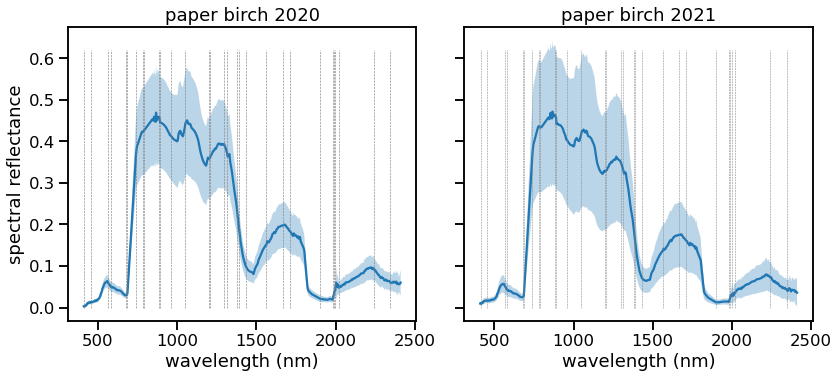

In [300]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = birch_2020.mean(axis=0).values[:-8]/10000
err = birch_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = birch_2021.mean(axis=0).values[:-8]/10000
err = birch_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("paper birch 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("paper birch 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

axs[0, 0].vlines(x=hyspex_wavelengths[selected_band_idx[:-20]], ymin=0, ymax=0.62, colors='grey', ls='--', lw=0.6)
axs[0, 1].vlines(x=hyspex_wavelengths[selected_band_idx[:-20]], ymin=0, ymax=0.62, colors='grey', ls='--', lw=0.5)

plt.tight_layout()   

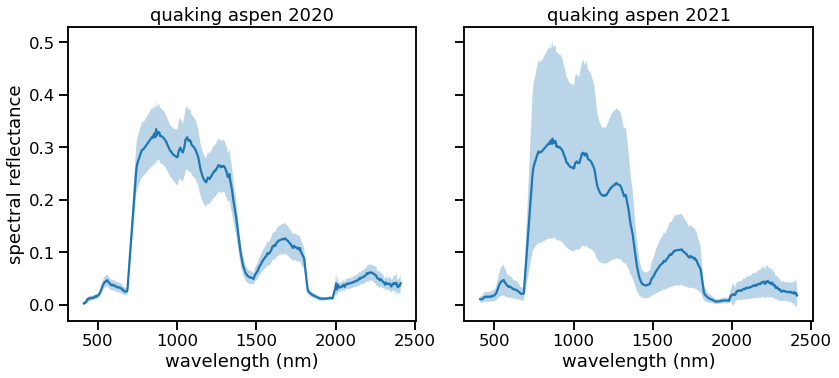

In [286]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = aspen_2020.mean(axis=0).values[:-8]/10000
err = aspen_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = aspen_2021.mean(axis=0).values[:-8]/10000
err = aspen_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("quaking aspen 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("quaking aspen 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

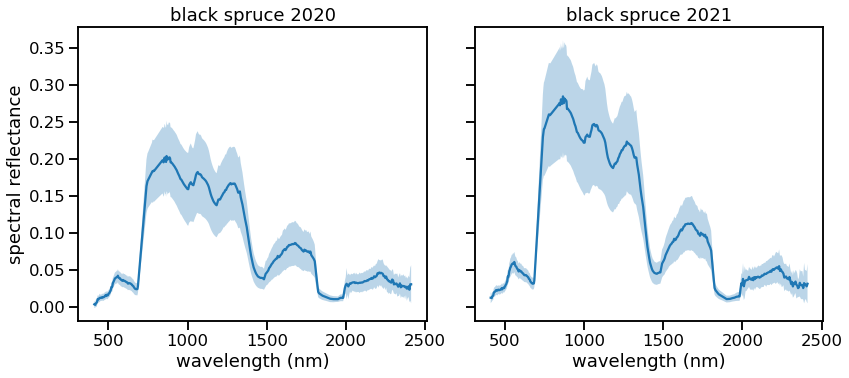

In [287]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = bspruce_2020.mean(axis=0).values[:-8]/10000
err = bspruce_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = bspruce_2021.mean(axis=0).values[:-8]/10000
err = bspruce_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("black spruce 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("black spruce 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

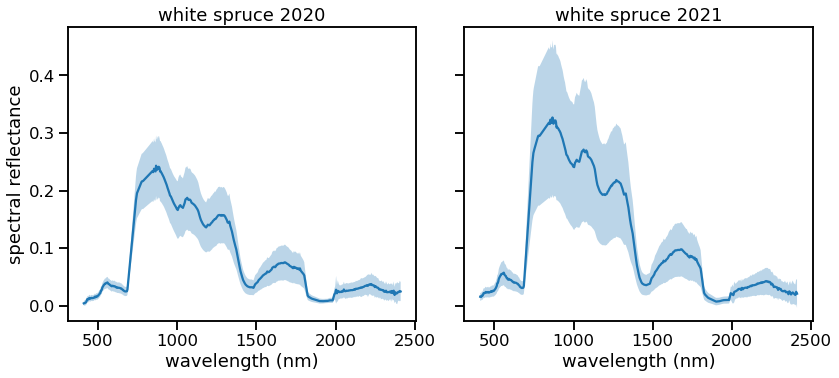

In [301]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = wspruce_2020.mean(axis=0).values[:-8]/10000
err = wspruce_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = wspruce_2021.mean(axis=0).values[:-8]/10000
err = wspruce_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("white spruce 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("white spruce 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

In [262]:
species = ['paper birch', 'quaking aspen', 'white spruce', 'black spruce', 'graminoid', 'gravel']

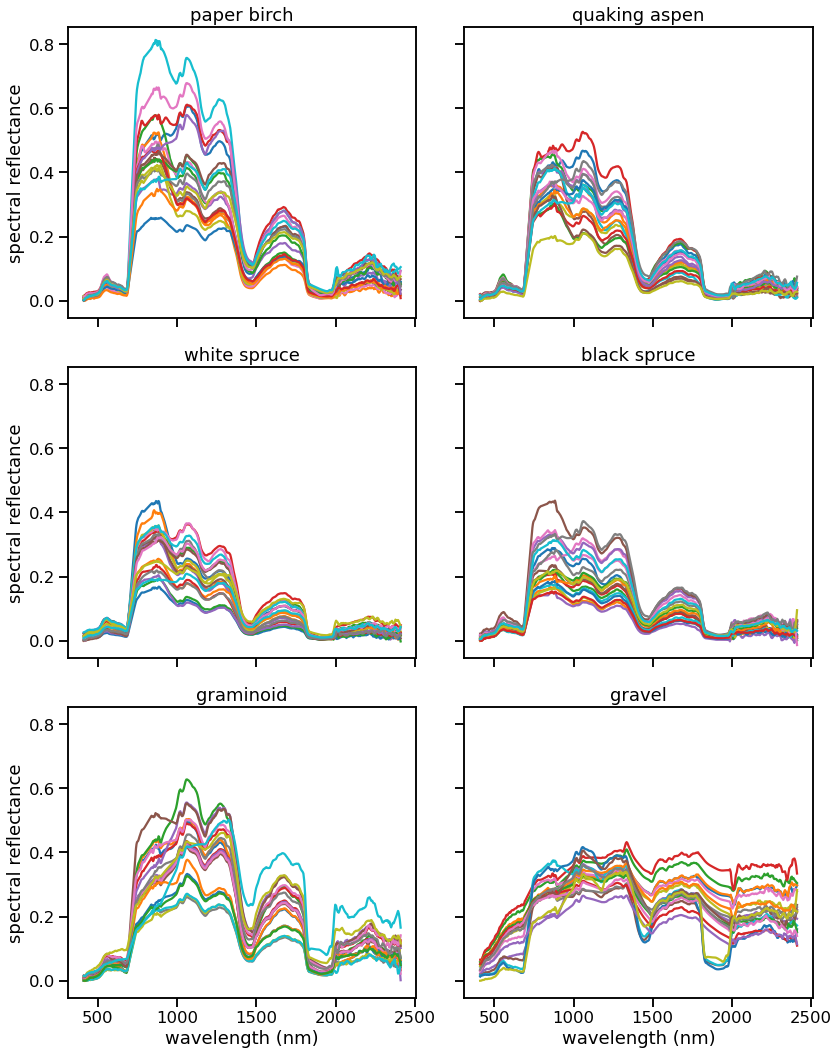

In [250]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)

for ii, ax in enumerate(axs.flatten()):    
    for spec in spectra_forplot[spectra_forplot['species']==species[ii]].spectrum: 
        ax.plot(hyspex_wavelengths[:-18], munge.smooth_spectrum(spec, clip_bands=8))
        ax.set_title(f"{species[ii]}") 
axs[0, 0].set_ylabel("spectral reflectance")
axs[1, 0].set_ylabel("spectral reflectance")
axs[2, 0].set_ylabel("spectral reflectance")
axs[2, 0].set_xlabel("wavelength (nm)") 
axs[2, 1].set_xlabel("wavelength (nm)") 

plt.tight_layout()   

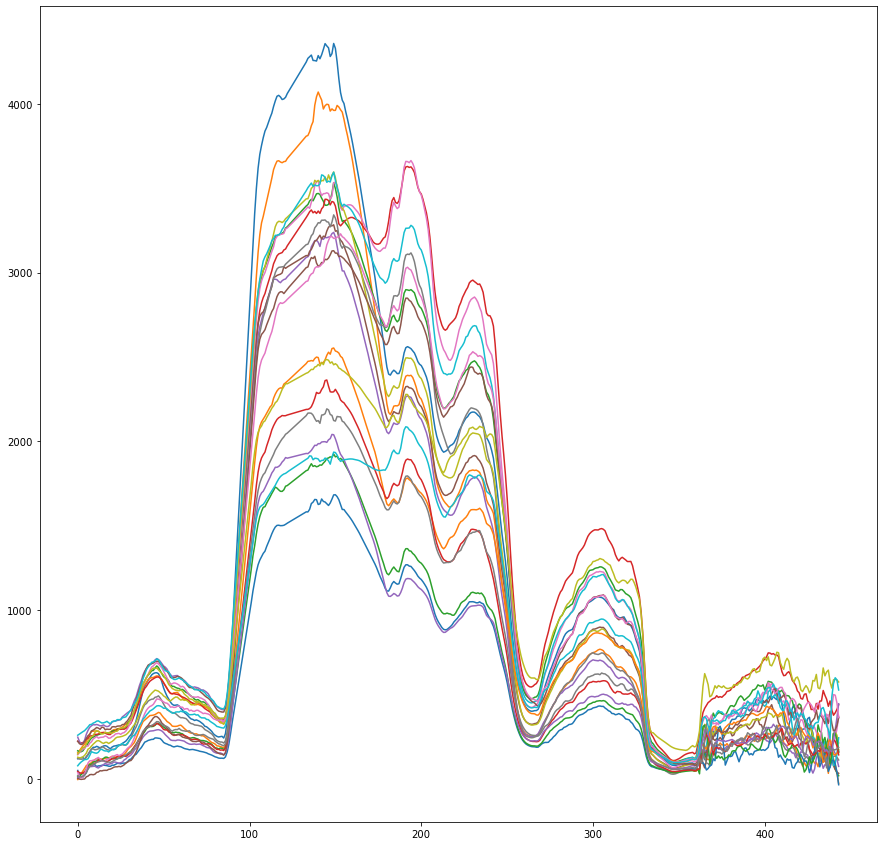

In [214]:
fig, aax = plt.subplots(figsize=(15, 15))



---

In [117]:
len(samplespectra_fortraining)

119

In [279]:
samplespectra_fortraining = samplespectra
spectra_fortraining = pd.DataFrame.from_records(samplespectra_fortraining)
spectra_fortraining

,fid,species,event,flightline,vegclass,context,spectrum
0,559,white spruce,20210803-BC,04,None,crown,"[108.0, 148.0, 109.0, 138.0, 115.0, 126.0, 127..."
1,562,white spruce,20210803-BC,04,None,crown,"[153.0, 163.0, 192.0, 198.0, 207.0, 211.0, 248..."
2,566,paper birch,20210803-BC,04,None,crown,"[78.0, 74.0, 58.0, 86.0, 82.0, 94.0, 89.0, 142..."
3,568,paper birch,20210803-BC,04,Bluejoint,crown,"[59.0, 57.0, 67.0, 95.0, 100.0, 92.0, 133.0, 1..."
4,571,paper birch,20210803-BC,04,Bluejoint,crown,"[104.0, 113.0, 86.0, 128.0, 137.0, 130.0, 140...."
...,...,...,...,...,...,...,...
114,661,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[73.0, 41.0, 55.0, 73.0, 81.0, 56.0, 77.0, 136..."
115,659,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[25.0, 21.0, 42.0, 81.0, 69.0, 120.0, 94.0, 11..."
116,689,graminoid,20210803-BC,02,Wet sedge meadow,open,"[128.0, 151.0, 124.0, 107.0, 161.0, 135.0, 180..."
117,685,graminoid,20210803-BC,02,Wet sedge meadow,open,"[152.0, 124.0, 163.0, 155.0, 169.0, 193.0, 238..."


In [140]:
fn = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
with xr.open_dataset(fn, engine="rasterio") as ds:
    ds.attrs['long_name'] = "spectral reflectance, %*100"
    ds.attrs['name'] = "spectral reflectance, %*100"
    ds['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"
    hyspex_wavelengths = ds.wavelength.data

In [35]:
fn = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testdata = get_dataset(fn)
sampledf = get_singlefilesampledf(row)
pt = sampledf.iloc[0].geometry
testdata.band_data.sel(x=pt.x, y=pt.y, method='nearest').values

array([  142.,   163.,   152.,   144.,   169.,   167.,   167.,   193.,
         161.,   186.,   191.,   197.,   194.,   179.,   186.,   196.,
         193.,   186.,   175.,   185.,   180.,   196.,   214.,   185.,
         206.,   204.,   197.,   214.,   211.,   218.,   225.,   240.,
         241.,   258.,   285.,   301.,   308.,   334.,   339.,   361.,
         370.,   381.,   398.,   393.,   383.,   399.,   399.,   400.,
         394.,   371.,   374.,   377.,   353.,   342.,   339.,   322.,
         324.,   343.,   328.,   318.,   318.,   334.,   318.,   314.,
         312.,   311.,   300.,   302.,   294.,   288.,   300.,   292.,
         277.,   280.,   285.,   269.,   273.,   256.,   257.,   246.,
         236.,   236.,   229.,   229.,   226.,   233.,   237.,   256.,
         364.,   472.,   580.,   689.,   797.,   905.,  1013.,  1121.,
        1230.,  1338.,  1446.,  1554.,  1663.,  1771.,  1879.,  1987.,
        2095.,  2144.,  2158.,  2202.,  2242.,  2281.,  2320.,  2359.,
      

In [64]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
563,20210803-BC,04,white spruce,None,crown,POINT (436685.995 7178216.899)
423,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437026.109 7176200.958)
346,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437129.028 7176208.997)
292,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436972.888 7176336.933)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
...,...,...,...,...,...,...
555,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
556,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
557,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
558,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [40]:
vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=20)

,fileprefix,flightline,species,vegclass,context,geometry
421,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437024.876 7176200.071)
297,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436984.083 7176329.768)
343,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437132.184 7176207.764)
440,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437098.256 7176582.899)
438,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437105.111 7176567.908)
843,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437274.998 7176618.834)
424,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437045.884 7176196.915)
442,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437120.004 7176564.949)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
835,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437064.152 7176639.981)


2022-05-09 12:18:17,698 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fdd201e1a30>>, <Task finished name='Task-14' coro=<Worker.close() done, defined at /Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/worker.py:1385> exception=CommClosedError('ConnectionPool not running. Status: Status.closed')>)
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/core.py", line 1089, in connect
    comm = await fut
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/

In [37]:
treespecies = ['paper birch', 'quaking aspen', 'black spruce', 'white spruce']

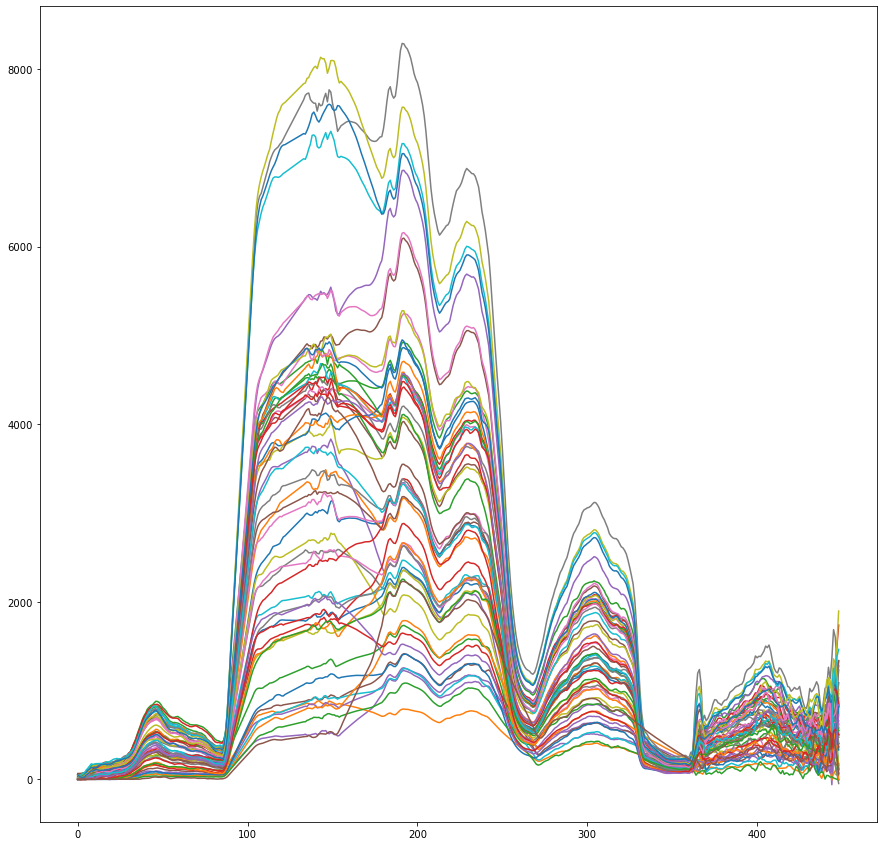

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['paper birch']: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

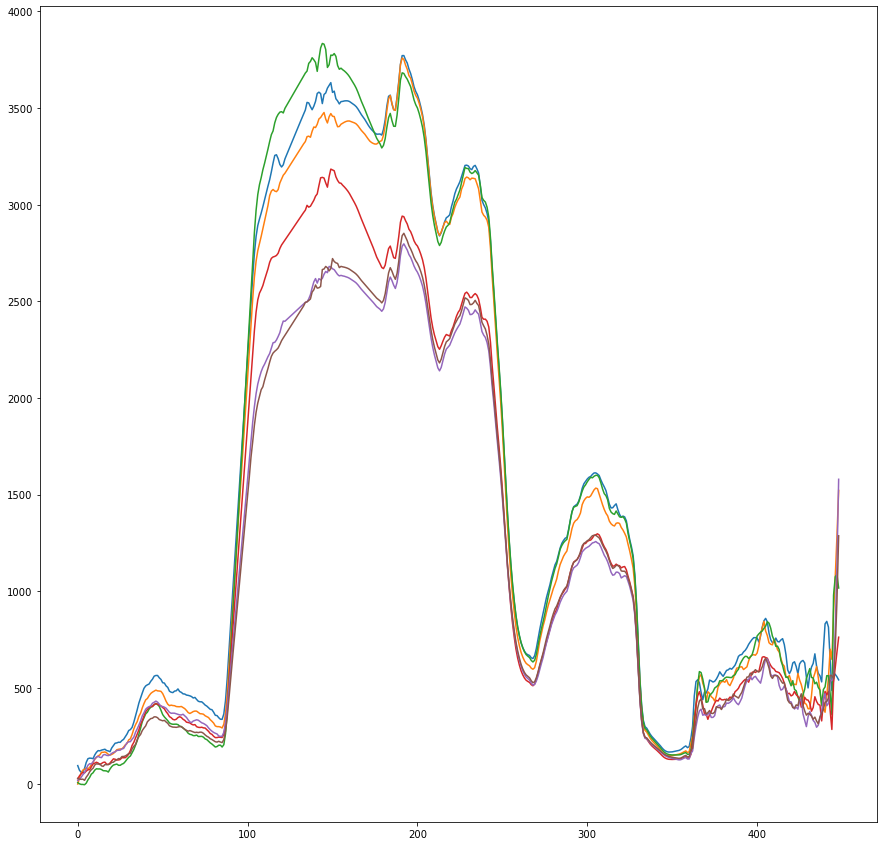

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['quaking aspen'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

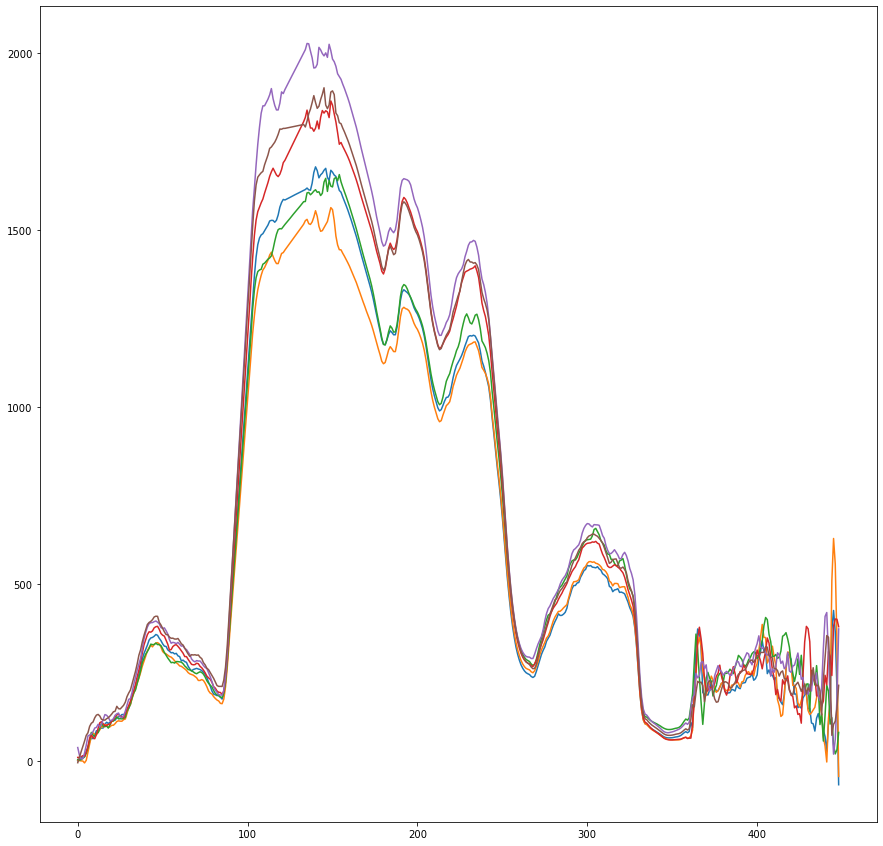

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['black spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

In [26]:
skipSWIR = -15
wavelengths = testdata.wavelength.values[:skipSWIR]

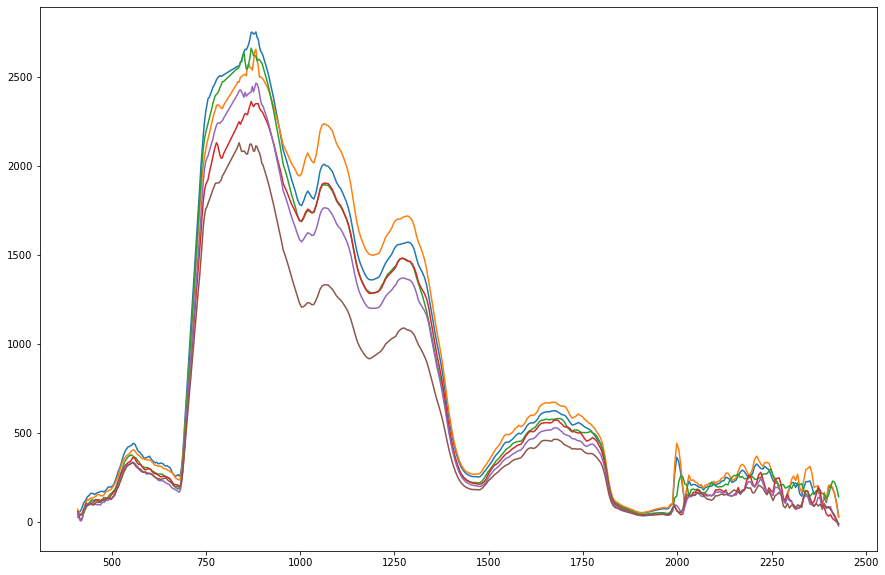

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

for pt in samples['white spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:skipSWIR]
    ax.plot(wavelengths, savgol_filter(spec, 7, 2))

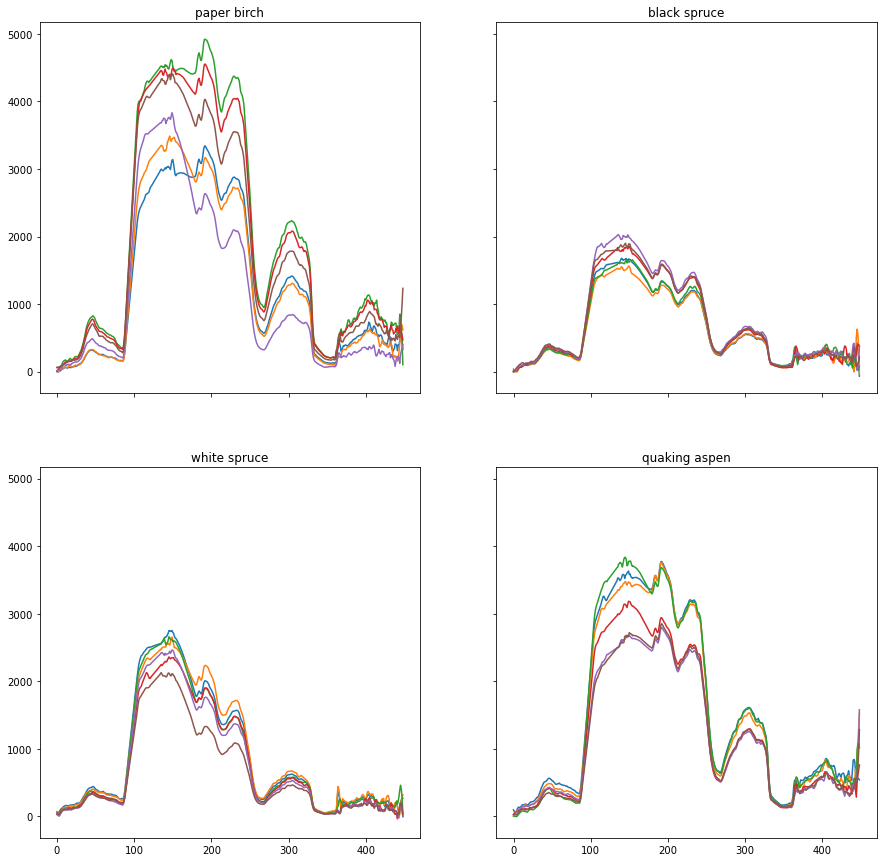

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)


for ii, ax in enumerate(axs.flatten()):
    for pt in samples[speciesnames[ii]][:6]: 
        spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
        ax.plot(savgol_filter(spec, 7, 2))
        ax.set_title(speciesnames[ii]) 
    

In [43]:
import psutil

proc = psutil.Process()
print(proc.open_files())

[popenfile(path='/Users/christine/.ipython/profile_default/history.sqlite', fd=63), popenfile(path='/Users/christine/.ipython/profile_default/history.sqlite', fd=65), popenfile(path='/Users/christine/miniconda3/envs/python38_geo/share/proj/proj.db', fd=71), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.hdr', fd=132), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq', fd=156), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.hdr', fd=158), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq', fd=159), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_05_VNIR_SWIR_rad_

In [ ]:
testdata